# Tweepy Notebook

Notebook will provide an example of how to use the Tweepy package to read tweets, do some simple processing and then load them into pandas.

The first thing you need to do is log into **Twitter** and create an application.

[Twitter Apps](https://apps.twitter.com)

Select the **Create New App** button

and fill out the application information.

You will ultimately need the following pieces of information:

- access_token
- access_token_secret
- consumer_key
- consumer_secret


## AWS Comprehend Sentiment Analysis

After collecting all of the tweets and example of using the AWS Sentiment analysis API is demonstrated.



In [1]:
import tweepy
import json
import re
import pandas as pd
from config import Config as cfg
import matplotlib.pyplot as plt


In [2]:
access_token = cfg.access_token
access_token_secret = cfg.access_token_secret
consumer_key = cfg.consumer_key
consumer_secret = cfg.consumer_secret

tweet_file_name = 'tweets.txt'
file_mode = 'a'

Create a tweepy OAuthHandler, to be used when we stream the tweets.

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)


In [4]:
class MyStreamListener(tweepy.StreamListener):
    def __init__(self, api=None, file_name='tweets.txt', mode='a', max_tweets=300):
        super(MyStreamListener, self).__init__()
        self.num_tweets = 0
        self.file = open(file_name, mode)
        self.max_tweets = max_tweets

    def on_status(self, status):
        tweet = status._json
        self.file.write( json.dumps(tweet) + '\n' )
        self.num_tweets += 1
        if self.num_tweets < self.max_tweets:
            return True
        else:
            return False
        self.file.close()

    def on_error(self, status):
        print(status)


Select a filter word or words.  Becareful to pick a set of filter words that will give you hits on tweets quickly, else the stream will wait until it has enough tweets before it exits.

In [5]:
filter_words=['trump']

In [6]:
l = MyStreamListener()
stream = tweepy.Stream(auth, l, file_name=tweet_file_name, mode=file_mode, max_tweets=100)

# filters twitter streams to capture data by keywords
stream.filter(track=filter_words)


### Post process the collected tweets

There is clearly a number of things we can do to clean up the tweet text.  I wanted this to be a simple example of some minimal post processing

In [7]:
def word_in_text(word, tweet):
    word = word.lower()
    text = tweet.lower()
    match = re.search(word, text)

    if match:
        return True
    return False


In [8]:
tweets_data = []
tweets_with_words = ['russia', 'SeanHannity', 'Mueller', 'clinton']
with open(tweet_file_name, 'r') as tweets_file:
    for line in tweets_file:
        tweet = json.loads(line)
        user = tweet['user']
        tweet['user_id'] = user['id']
        tweet['screen_name'] = user['screen_name']
        tweet['len'] = len(tweet['text'])
        if tweet['text'].startswith('RT '):
            tweet['retweet'] = 1
            tweet['text'] = tweet['text'].replace('RT ', '', 1)
        else:
            tweet['retweet'] = 0
        for word in tweets_with_words:
            tweet[word] = 1 if word_in_text(word, tweet['text']) else 0
        tweets_data.append(tweet)


In [9]:
columns=['text', 'screen_name', 'len', 'retweet']
columns.extend(tweets_with_words)
df = pd.DataFrame(tweets_data, columns=columns)

print(df.head(20))
print(df.shape)

                                                 text     screen_name  len  \
0             @AlamoOnTheRise https://t.co/ukp07vXGqf        ne1for23   39   
1                     So true https://t.co/Vq9ayIAcAn        jend0315   31   
2   @sumariumcom: Cabello sobre ausencia de Trump ...   REACCI0NARIAA  139   
3   @TrumpTrainMRA4: @facebook \n@DiamondandSilk \...     Crowntiptoe  140   
4   @page88: Thread. Don’t think this overstates m...    JadeJensen29   80   
5   @SpeakerRyan @SenateMajLdr #ProtectMueller #Pr...      Terryg1979   85   
6   @funder: Trump sending troops to the border, i...   IamBrooklyn31  140   
7   @AnnCoulter: Mueller is DYING to get fired.  T...          SPeek1  139   
8   Yup.\nTrain wreck coming.\n#Resist\n#Resign\n#...       titeman50   73   
9   @drscott_atlanta: #FBI raids @realDonaldTrump’...       Jdflygirl  140   
10  @MSNBC: The New York Times reports special cou...     hani_azer11  140   
11  @CoreyLMJones: Mark Zuckerberg said that Faceb...  Mikeypoos

In [10]:
df.to_csv('./data/tweets.csv')

# AWS Comprehend Sentiment Analysis

This section assumes you have an AWS account, and you have created an IAM user and generated the access tokens.

## AWS Comprehend API

To use the comprehend API, and in particular the sentiment analysis api:

- *pip install awscli*
- *aws configure*
- supply your users access key and secret key which you get from the IAM console

See the following documents:
- [Python Boto3 API](https://boto3.readthedocs.io/en/latest/guide/quickstart.html)

- [Amazon Comprehend Documents](https://docs.aws.amazon.com/comprehend/latest/dg/what-is.html)

The above will setup the configuration in the default profile.


In [11]:
tweets_df = pd.read_csv('./data/tweets.csv')

In [12]:
import boto3
import json

In [13]:
comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')

For each of the tweets, call the sentiment API and add to the data frame the resulting sentimment, and the individual probabilities of the different sentiments.

In [15]:
for tweet in tweets_df['text']:
    response = comprehend.detect_sentiment(Text=tweet, LanguageCode='en')
    sentiment = response['Sentiment']
    sentiment_mixed = response['SentimentScore']['Mixed']
    sentiment_negative = response['SentimentScore']['Negative']
    sentiment_neutral = response['SentimentScore']['Neutral']
    sentiment_positive = response['SentimentScore']['Positive']
    tweets_df['sentiment'] = sentiment
    tweets_df['sentiment_mixed'] = sentiment_mixed
    tweets_df['sentiment_negative'] = sentiment_negative
    tweets_df['sentiment_neutral'] = sentiment_neutral
    tweets_df['sentiment_positive'] = sentiment_positive
    
    print(f"[{sentiment}\n{tweet}\n]")


[NEUTRAL
@AlamoOnTheRise https://t.co/ukp07vXGqf
]
[NEUTRAL
So true https://t.co/Vq9ayIAcAn
]
[NEUTRAL
@sumariumcom: Cabello sobre ausencia de Trump en Lima: “Que tristeza para los perritos que esperaban pasarle la lengua por los zapatos”…
]
[NEUTRAL
@TrumpTrainMRA4: @facebook 
@DiamondandSilk 
Mark Zuckerberg Declares Two Black Trump Chicks 
“ UnSafe for His Community “
🤪Liberalism i…
]
[NEUTRAL
@page88: Thread. Don’t think this overstates matters. https://t.co/EpKFaUBi62
]
[NEUTRAL
@SpeakerRyan @SenateMajLdr #ProtectMueller #ProtectRosenstein https://t.co/z9ihMbnVAM
]
[NEUTRAL
@funder: Trump sending troops to the border, is literally his way of making the military pay for the wall. Because the military themselv…
]
[NEUTRAL
@AnnCoulter: Mueller is DYING to get fired.  Then he'll be a martyr! A hero!  Otherwise, he's just a loser who couldn't find any crimes…
]
[NEUTRAL
Yup.
Train wreck coming.
#Resist
#Resign
#Impeach https://t.co/SGQMXZKaKR
]
[NEUTRAL
@drscott_atlanta: #FBI raids @re

[NEUTRAL
@tribelaw: Anyone advising Trump he has power to remove Mueller better read  In re Hennen (1839), reaff’d by CJ Taft (1926) and CJ Rober…
]
[NEUTRAL
@CNN: Special counsel Robert Mueller’s investigators met with members of President Trump’s legal team on the same day that the FBI was l…
]
[NEUTRAL
@NormEisen: I have analyzed thousands of conflicts as a gov ethicist, &amp; argument WH is floating that Rosenstein has 1 b/c he is a potent…
]
[NEUTRAL
@SaysHummingbird: 300,000 Americans vow to protest across all 50 states if Trump fires Mueller.

Retweet if you are one of them.

#Firep…
]
[NEUTRAL
Trump Hotel to Employees: Dont Hire Relatives https://t.co/StGr0Xn3kr
]
[NEUTRAL
@mog7546: #Maddow unveils NEW EVIDENCE REFUTING #Trump's claim that James Comey is lying about their conversations 

https://t.co/cbQdsp…
]
[NEUTRAL
@gabrielsherman: As Trump fumes about Cohen raid, Bolton and Kudlow are clashing with Kelly. My latest:
https://t.co/QER1fpfyKJ
]
[NEUTRAL
@pjbruno79: It's amazi

[NEUTRAL
@MaddowBlog: "the search of Cohen's office was not the work of Mueller's prosecutors. It involves a matter that the Mueller team came ac…
]
[NEUTRAL
@MZHemingway: "Many civil libertarians have remained silent about potential violations of President Trump’s rights b/c they strongly dis…
]
[NEUTRAL
@MikeTokes @jimmykimmel Mike, is that vid even legit⁉️ It has to be 20+ years old. trump sheep 🐑really love to go d… https://t.co/o4frm3C18l
]
[NEUTRAL
@RVAwonk: Wow. @maddow obtained Dana Boente's handwritten, contemporaneous notes from his conversations with James Comey. And those note…
]
[NEUTRAL
@SethAbramson: PLEASE RT If you strenuously and unambiguously object to Trump firing Deputy Attorney General Rosenstein or Special Couns…
]
[NEUTRAL
@RVAwonk: While questioning #Zuckerberg, Senators Tom Tillis &amp; Chuck Grassley both falsely claimed that the Obama campaign used the same…
]
[NEUTRAL
Schumer to Trump: Don't even think about firing Mueller https://t.co/eahaKhilyF via @YouTu

[NEUTRAL
@trcfwtt: trump is so angry and distraught over Cohen raid that he canceled a planned trip to Latin America without informing most of th…
]
[NEUTRAL
@matthewamiller: Does anyone still think he's not trying to cover up serious wrongdoing? There is really no other explanation left for h…
]
[NEUTRAL
@Amy_Siskind: Remember when Yates was fired and we said this is the end. 
Remember when Comey was fired and we said this is the end. 
Ou…
]
[NEUTRAL
@joss Correction: Trump is REVIVING the country!
]
[NEUTRAL
@lord_inario: —Y dijo: Ya no vamos a comprar en el extranjero lo que consumimos. Todo lo vamos a producir aquí.
— Jajaja, ese Trump cada…
]
[NEUTRAL
@AbelMunizJr: Can't wait for the movie about these events starring Tom Hanks. https://t.co/F14PaseiqM
]
[NEUTRAL
@goodoldcatchy: The 30 years from 1987 (the vote to abolish the Fairness Doctrine) to 2017 will be seen by historians as the pre-Trump e…
]
[NEUTRAL
@krassenstein: Trump Supporter Lou Dobbs posted the following Twitter pol

[NEUTRAL
@DonCorneliano2: (1) Se denuncia que Siria cometió un CRIMEN DE GUERRA por ataque de gas a civiles y Trump tomará una decisión en conjun…
]
[POSITIVE
Glory to God! I am thankful for the boldness of these men of God! https://t.co/f0SugsgISM
]
[NEUTRAL
@TheRickWilson: 1/ The crisis is upon us. Right now, Ryan and McConnell are convinced this is another Trump bluff, an exercise in his ga…
]
[NEUTRAL
@ItsMeCathi: Retweet of you're ready to take to the streets when Trump fires Mueller! 

#Resist https://t.co/jMAsbnaLLX
]
[POSITIVE
@marklhaag: Good thread https://t.co/RSJeZrRBpg
]
[NEUTRAL
@AnnaSilPrad: The Darkness my instinct is going!!!! #POTUS  is TWO Steps ahead🇺🇸KEEP the FAITH : you know you’re gonna live thru the rai…
]
[NEUTRAL
@funder: @CNN @ErinBurnett Alan Dershowitz hung out with Trump recently at Mar-a-Lago-Anyone listening to him needs to stop #AMJoy #Trum…
]
[NEUTRAL
@USAHotLips: STOP &amp; BREATHE‼️

@realDonaldTrump isnt going anywhere. What we all should be concern

[NEUTRAL
@SECNetwork: JK Scott led the @AlabamaFTBL team in prayer over President Trump when the Tide visited the White House.

He shared the sto…
]
[NEUTRAL
@joncoopertweets: Nothing has changed, folks. Donald Trump is STILL a lying, immoral, bigoted charlatan. He’s STILL a xenophobe. He’s ST…
]
[NEUTRAL
@dcexaminer: JUST IN: Trump wants James Comey jailed for mishandling classified information, lying to Congress https://t.co/fOhdImd2oA h…
]
[POSITIVE
@DearAuntCrabby: Amen! https://t.co/lCdps56t3H
]
[NEUTRAL
@SaysHummingbird: Jared Kushner &amp; Ivanka Trump have at least **$31,000,000 in debt**.

Yes. 31 M.I.L.L.I.O.N.

They should be fired from…
]
[NEUTRAL
@joeylaf @GOPChairwoman And your guy Trump has creditability...best joke of the day
]
[NEUTRAL
Republicans Might Want To Run Away From Trump This Year, But Not In West Virginia https://t.co/Kf5rt8GNaU
]
[NEUTRAL
@RealSaavedra Sure @maddow that’s why France &amp; UK assisted USA in the strike to cover for Trump. A suggestion to Am…

[POSITIVE
And yet Trump's cult will say this is fine as long as we're taking science out of schools and replacing it with Bib… https://t.co/zegbS9jyoK
]
[NEUTRAL
@starcrosswolf: Schumer has blasted Trump &amp; Republicans for knocking the tech industry over liberal bias. Schumer Got Massive Payout fro…
]
[NEUTRAL
I agree but I have a feeling Melania doesn't "need" to be on the cover of every magazine. Her presence is of a much… https://t.co/IbXrJIHp9P
]
[NEUTRAL
@LVNancy: James Comey was making decisions on the Clinton Email probe based on #Fakenews polls that falsely claimed she would win. #Come…
]
[NEUTRAL
@LifeZette: After airstrikes against Syria, Trump 'wants God's help not only in the presidency, but as he deals with problems' around th…
]
[NEUTRAL
Pretty sure most of his cronies and bootlickers deserve prison, too. https://t.co/shMsDmzTIF
]
[NEGATIVE
@ccatzm: @thehill Trumps voters must be feeling trapped &amp; are eating off their own legs regretting voting for this awful Trump

[NEUTRAL
axios "If Trump follows through on this alleged commitment to Macron, it would be one of the biggest and most ab… https://t.co/JPjheRRD1t
]
[NEUTRAL
We love Trump here in Texas https://t.co/lhqExmhGpI
]
[NEUTRAL
@KFILE: More Than One-Fifth Of The Trump Campaign's Spending This Year Has Been On Legal Fees https://t.co/2J8eYnZBdH
]
[NEUTRAL
@funder: “I don’t know the guy” @SpeakerRyan said about Comey. This BS response from Paul Ryan is on the same level of Trump’s attacks.…
]
[NEUTRAL
Trump defiende su anuncio de Misión Cumplida por ataque en Siria https://t.co/7NHqLmeVf5  ...
]
[NEUTRAL
Hillary was robbed. https://t.co/SmfupYjJ4c
]
[NEUTRAL
@jerome_corsi: I am doing a LIVE STREAM NOW on my YouTube Channel (jrlcorsi) https://t.co/1adapldriP Saturday, April 14, 2018 at 6:10 pm…
]
[NEUTRAL
@sweetbetty25: @realDonaldTrump you’re the reason the scums are loose it’s on your racist pathetic self https://t.co/Erd3WjSEoo
]
[NEUTRAL
@realDonaldTrump 💩@POTUS 💩 https://t.co/L6DwZZxDmT
]
[

[NEUTRAL
@CNNnewsroom: Democratic Rep. Ted Lieu says Trump's tweet on attorney-client privilege this morning "shows once again that the President…
]
[NEUTRAL
Interesting list of people who thought that Powell wasn't a 'racialist' when he clearly was a shit stirring racist… https://t.co/D0gCMNSMN7
]
[NEUTRAL
@jwcnyc: @ThemanDaryl @pr0truth @KeokisDad @realDonaldTrump She doesn’t have a real job because she went to Trump University.
]
[NEUTRAL
@N3MO83: Isn't ironic that when the left puts forth a theory it's investigative journalism but when the right does it's a conspiracy. Re…
]
[POSITIVE
Love when liers call other liers liers. https://t.co/xZZ9aDu6fo
]
[NEUTRAL
@Shoq: .@iwrotesham Jeff Zucker confessed that perhaps giving Trump all that rally coverage "was a mistake" during the campaign.  

Then…
]
[NEUTRAL
tarmac-tarmac ✅✅🗣🗣Q Anon Update - Trump Tweets and the Tarmac Meeting https://t.co/FNDhuquShT via @YouTube
]
[NEUTRAL
@tedlieu: Today is Sunday. That means we all need to ask again

[NEUTRAL
@JacobAWohl: This is why we elected President Trump https://t.co/OkYQg3Qgyy
]
[NEGATIVE
@mydogisadem: I hate this man so much it makes me sick. He has no idea the hardships this will cause to our most vulnerable citizens nam…
]
[NEUTRAL
@MsLonesomeBlues: @IanHartley_ First question why did Trump pretend to criticise Putin? Why did  Putin pretend to be outraged. Answer: A…
]
[NEUTRAL
@hapoelpolitics: Nothing pisses me off like "Labour" MPs backing Trump/May's bombing of Syria. I really don't see any reason for them to…
]
[NEUTRAL
@junogsp5: Every follower who supports Donald J Trump needs to retweet this video from 
RNC where Dems Attack 
Comey Credibility 
TY Mat…
]
[NEUTRAL
Trump fears two men: Mueller and De Niro (opinion) https://t.co/dpKO54zTu8
]
[NEUTRAL
@charliekirk11: The Democrats aren’t afraid Donald Trump will fail, they are afraid he will succeed
]
[NEUTRAL
Can't help it.  Trump...cabinet.. I think IKEA. We're screwed. https://t.co/q80YJbFlA8
]
[NEUTRAL
@JohnWDean: 

[NEUTRAL
@RonaldKlain: In 2014, Donald Trump urged that one of Franklin Graham's evangelical doctors be left to die in West Africa when he contra…
]
[NEUTRAL
@JohnWDean: Trump only likes being president because he loves the attention. He particularly likes the attention of campaigning. He’s NO…
]
[NEUTRAL
@mmpadellan: I may not have agreed with many things Barbara Bush said, but the former First Lady never minced her words about trump.

I…
]
[NEUTRAL
@chrisvega25: 🌎IN A PERFECT WORLD🌍 

If none of these 🤡’s grew up “privileged”

Trump - would be in prison &amp; registered sex offender

Sa…
]
[NEUTRAL
@kylegriffin1: The White House kept it quiet, but Axios reports that Trump nearly blocked Mike Pence from getting his chosen national se…
]
[NEUTRAL
@Mmarty1230: Poll: Trump approval hits highest mark since first 100 days in office https://t.co/pc96tUEdsy via @realalexjones WAHOO WAHO…
]
[NEUTRAL
@brycetache: If you've followed me a while, you know optimism is my thing. I've always seen ho

[NEGATIVE
WHAT A MORON... https://t.co/LVYN1dcwRr
]
[NEUTRAL
@johncusack: Assholes- trump enablers  obedient political House pets - ⬇️ read   https://t.co/jW16ZzTeL3
]
[NEUTRAL
@Reuters: France's Macron says he persuaded Trump to keep troops in Syria https://t.co/B3cApIch8s https://t.co/Y6SS3Kqp2y
]
[NEGATIVE
@MargaretJay7: @realDonaldTrump Yes trump, we spent a billion dollars bombing 2 empty buildings in Syria...great job loser!!!
]
[NEUTRAL
@StephenMilIer: Donald Trump is one of the only US Presidents to survive a coup. Liberals can whine like babies, but Trump is here to st…
]
[NEUTRAL
@allanbrauer: They were reportedly headed to DC for positions in the Trump administration. https://t.co/yUF2Vm0Sbr
]
[NEUTRAL
@andres20ad: Hace años EEUU atacó a Irak en base a una mentira, como lo eran las "armas de destrucción masiva" y se quedó con el petróle…
]
[NEUTRAL
@dtxErgaOmnes: .@BetoORourke would vote to impeach Trump, but right now he’s “focused on the issues” to beat Ted Cruz. #BetoForT

[NEUTRAL
@JeffRee42838945 START ETTING THE FACTS...LOL tRUMP HAS BEEN PUT IN HISTORY ALREDY AS THE MOST CORRUPT BIGGEST LIAR… https://t.co/1SrKVUmJIC
]
[NEUTRAL
@RonaldKlain: In 2014, Donald Trump urged that one of Franklin Graham's evangelical doctors be left to die in West Africa when he contra…
]
[NEUTRAL
@FoxNews @Franklin_Graham Trump is not religious, does not pray and has gone to church twice since he was inaugurated.
]
[NEUTRAL
@SethAbramson: 10/ Here's a link to the 79 pages of McCabe-Comey emails that Judicial Watch uncovered.

If you want to understand how Tr…
]
[NEUTRAL
@krassenstein: 18 Hours ago the White House Press Secretary, Sarah Sanders released a photo of Trump being briefed on Syria...

The Prob…
]
[NEUTRAL
@tedlieu: Today is Sunday. That means we all need to ask again: Why is Jared Kushner still a Senior White House Advisor? https://t.co/KA…
]
[NEUTRAL
@MSNBC: Rep. Maxine Waters: President Trump is perhaps "most deplorable human being" I've ever encountered https:

[NEUTRAL
@CollinRugg: If you are no longer a Trump supporter because of the Syria strikes, you were never a supporter in the 1st place.

We don’t…
]
[NEUTRAL
@BethShell: @SusanDa50168535 @Alt_Spicerlies @renato_mariotti Help me out here...is that Dersh &amp; Graham with Leonard Blavatnik...Putin c…
]
[NEUTRAL
@BravenakBlog Also, mind the timing of the chemical attacks. Trump impulsively blurted out that we were getting out… https://t.co/goy9haTi1W
]
[NEUTRAL
@DTrumpPoll: Do you approve of @realDonaldTrump's performance as @POTUS?

#TheResistance #MAGA #Trump

48hrs to vote &amp; RT 😊
]
[NEUTRAL
@jdice03: “Perception is more important than reality.  If someone perceives something to be true, it is more important than if it is in…
]
[NEUTRAL
@C_3C_3: NYPD discovered Hillary’s emails on Weiner’s laptop during their underage sexting investigation.

McCabe, Priestap &amp; Toscas cov…
]
[NEUTRAL
@bakers_bread: Tell @POTUS Trump how he's doing,send him a message.Stop the CHEM TRAILS!! MASS AR

[NEUTRAL
@FoxNews: .@dangainor: Trump strikes Syria, media fire back, and other examples of their war against the president https://t.co/mMI2kFU7…
]
[NEUTRAL
@RockinHits: The Real Reason Evangelical "Christians" Don't Care About Trump's Sordid Sexual Behavior https://t.co/5hZZCkRIwg
]
[NEUTRAL
@tedlieu: Today is Sunday. That means we all need to ask again: Why is Jared Kushner still a Senior White House Advisor? https://t.co/KA…
]
[NEUTRAL
@RealEagleWings: .@KellyannePolls: "The president took action here that was not impulsive, and was very decisive."  Anyone who thinks Tr…
]
[NEUTRAL
@SusanStormXO: Dear @DineshDSouza 
I didn’t know you were still having to deal with this ISSUE ; Obama did . 
His ruthless Corrupt FBI C…
]
[NEUTRAL
@ElJeringasLoko: esperate a que veamos infinity war pinche trump
]
[NEUTRAL
@FMoniteau: #Ivanka is not qualified to be representing the U.S.  This has to stop.

#IvankaTrump #SaturdayMorning #TheResistance #MAGA…
]
[POSITIVE
@caroltracy8: Good move. 
Necessa

[NEUTRAL
More traitors in the Nazi kakistocracy. #VoteOutAllRepublicans2018 #ImpeachTrumpPence #EndTheGOP https://t.co/xjmRv2NxGH
]
[NEUTRAL
@gatewaypundit: Breaking: Comey Lied About Never Seeing Trump Laugh: His Own Memo Records That Trump Laughed @KristinnFR https://t.co/wJ…
]
[NEUTRAL
@Truthseeker126: Great breakdown of Trump’s foreign policy. “...Trump’s realpolitik genius lay not in ideology, but in grasping the core…
]
[NEUTRAL
@costareports: Professor Tribe’s take is widely shared by Democrats in Congress — and mostly privately by some Republicans who fear a cr…
]
[NEUTRAL
@aravosis: The GOP House really f’d this one up. Now the entire country has the Comey memoes, and we’re getting CNN’s &amp; MSNBC’s spin, in…
]
[NEUTRAL
@Shareblue: Trump team extremely worried ‘fixer’ will squeal on him to the feds
https://t.co/AWBRte6RFu
]
[NEUTRAL
@Lawrence: EXCLUSIVE: 

Trump lawyer tells me Michael Cohen case could lead to impeachment. 

@TheLastWord 10pm
]
[NEUTRAL
@tracybeanz: In case 

[NEUTRAL
@tedcruz: The contrast couldn’t be greater: Beto supports open borders, aggressive gun control &amp; impeaching the President. In contrast,…
]
[NEUTRAL
@RepAdamSchiff: Congress can’t prohibit the President from abusing the pardon power, but we can ensure that if he uses it to shield hims…
]
[NEUTRAL
@thehill: #BREAKING: Comey memo: Trump said Putin praised Russian hookers as "the most beautiful in the world" https://t.co/AwFBNRkHzG h…
]
[NEUTRAL
@MikeO__Posc: He tried to kill trump😹💯 idk bro name, but he look like a “Chad” 
#FreeMyNiggaChad 😎 https://t.co/14rGYYnDND
]
[NEUTRAL
Hoooooooooooo boy..... https://t.co/ust2Pf75r4
]
[NEUTRAL
@rolandscahill: Trump hiring Giuliani is as if OJ Simpson hired Charles Manson to join his legal team
]
[NEUTRAL
@papacarl1956: Who is Rudy Giuliani really? The question remains
but will Mueller find out?...Tic ...Toc....Tic....Toc
#RudyGiuliani is…
]
[NEUTRAL
@jerome_corsi: Rod Rosenstein (trying desperately to save his job) JUST TOLD @realDonald

[NEUTRAL
@yoalexrapz: And here we have a rare look at a liberal having an exorcism. https://t.co/BMgVr14LIZ
]
[NEUTRAL
@ABC Screw Russians, they created that problem by electing Trump
]
[NEUTRAL
@SaysHummingbird: Ladies and gentlemen,

The President of the United States is exploiting a meeting with a foreign head of state to adve…
]
[NEUTRAL
@funder: Here's video of Rudy Giuliani getting groped and kissed by Trump while in drag. https://t.co/t1NzwOnYvX
]
[NEUTRAL
@JuddLegum: Notable from the memos that Trump told Comey multiple times that he didn’t stay overnight at the Moscow Ritz which, accordin…
]
[NEUTRAL
@KMGGaryde: Amy, sorry your career failed.  Lucky for you it's America &amp; you can start over.  You can wait on tables, work you way back…
]
[NEUTRAL
@MAGAPILL: Once this all backfires on the left completely,
Everyone's eyes will be open to the truth.
There will be no denying it, no sp…
]
[NEUTRAL
@funder: BREAKING: Jared Kushner’s family real estate company got a federal grand-

[NEUTRAL
Hannity: Good news for Trump, crushing blows for the left https://t.co/hHKuzVu1TM https://t.co/KYwZUWUMuP
]
[NEUTRAL
@BradMossEsq: Oh. My. God. 

The day after @SallyQYates tells McGahn that Flynn is compromised, Trump tells Comey he’s concerned about F…
]
[NEUTRAL
Trump will skip Barbara Bush funeral, sending first lady https://t.co/VoLtrRSQ8u https://t.co/SpZ3hTqZp8
]
[NEUTRAL
DOJ delivers Comey memos to Congress: DOJ delivers Comey memos to Congress  PoliticoComey's Memos on Trump to Be Re… https://t.co/ps0N9cH5oc
]
[NEUTRAL
@ACLU: Yet again the courts have rejected Jeff Sessions' illegal attempts to bully cities into carrying out Trump's anti-immigrant agend…
]
[NEUTRAL
@OK_Dumbass: @AriMelber @maddow WOW!  Trump told Comey he never spent a night in Russia for the 2013 Miss Universe pageant?  Got right i…
]
[NEUTRAL
@Non_MSM_News: Giuliani: Trump can build wall by executive order https://t.co/bf2jEuUzuS
]
[NEUTRAL
@misslaneym: When he first became President, Trump had a pe

[NEUTRAL
@RepAdamSchiff: In 2017, @timkaine and I wrote to @POTUS to ask for the legal justification for the Syria strike. We never heard back.…
]
[NEUTRAL
@MikeO__Posc: He tried to kill trump😹💯 idk bro name, but he look like a “Chad” 
#FreeMyNiggaChad 😎 https://t.co/14rGYYnDND
]
[NEUTRAL
@JimCarrey: The only ‘Sh*%hole’ Trump should worry about is the one under his nose from which he is constantly defecating. #pottytrainpo…
]
[NEUTRAL
@MAGAPILL: Once this all backfires on the left completely,
Everyone's eyes will be open to the truth.
There will be no denying it, no sp…
]
[NEUTRAL
@ChadBown: Is Trump in a Trade War with China?

No**

BUT there are A LOT of tariffs, dates, products, data (and tariffs!) to keep track…
]
[NEUTRAL
@realJohnnyZipp: Rudy Giuliani Joins Trump’s Legal Team and His First Task Will Have You CHEERING! https://t.co/MpxyCqFqv2 via @truthfee…
]
[NEUTRAL
@JuddLegum: Notable from the memos that Trump told Comey multiple times that he didn’t stay overnight at the Mosco

In [16]:
tweets_df.to_csv('./data/tweets_sentiment.csv')

## Wordcloud

Lets setup a word cloud to show the words in the tweets


In [69]:
from os import path
from wordcloud import WordCloud

tweets_df = pd.read_csv('./data/tweets_sentiment.csv')

In [70]:
# remove urls
regex = re.compile(r"http.?://[^\s]+[\s]?")
tweets_df.text.replace(regex, "", inplace=True)

In [71]:
# remove user name
regex = re.compile(r"@[^\s]+[\s]?")
tweets_df.replace(regex, "", inplace=True)

In [63]:
# html encoded characters
for remove in map(lambda r: re.compile(r), ["&lt;", "&gt;", "&quot;", "&amp;", "w/o", "w/"]):
    tweets_df.replace(remove, "", inplace=True)

In [84]:
# remove Donald, Trump, President, etc to get a better idea of what people are saying
for remove in map(lambda r: re.compile(r), ["Trump", "President", "Donald", "amp", "don", "trump", "will", "say", "said", "new", "day"]):
    tweets_df.replace(remove, "", inplace=True)

(-0.5, 399.5, 199.5, -0.5)

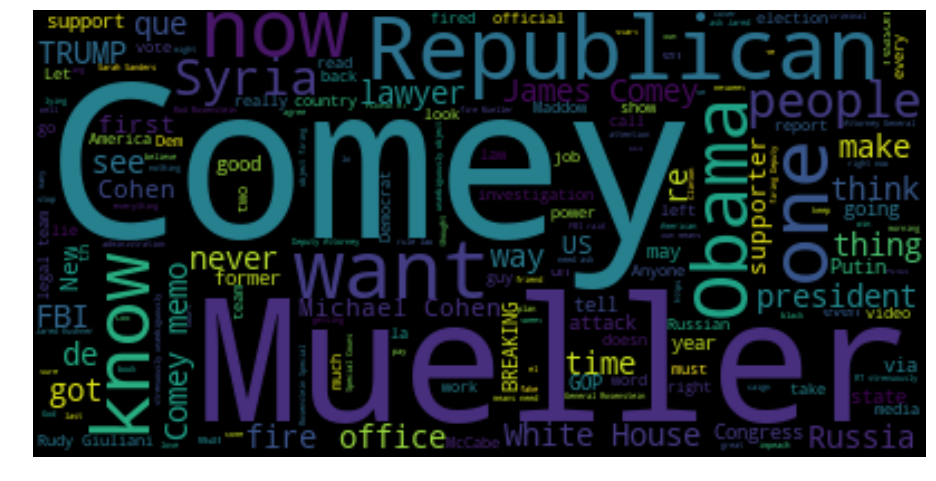

In [85]:

# Generate a word cloud image
text = ' '.join(tweets_df['text'])
wordcloud = WordCloud().generate(text) #WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


(-0.5, 399.5, 199.5, -0.5)

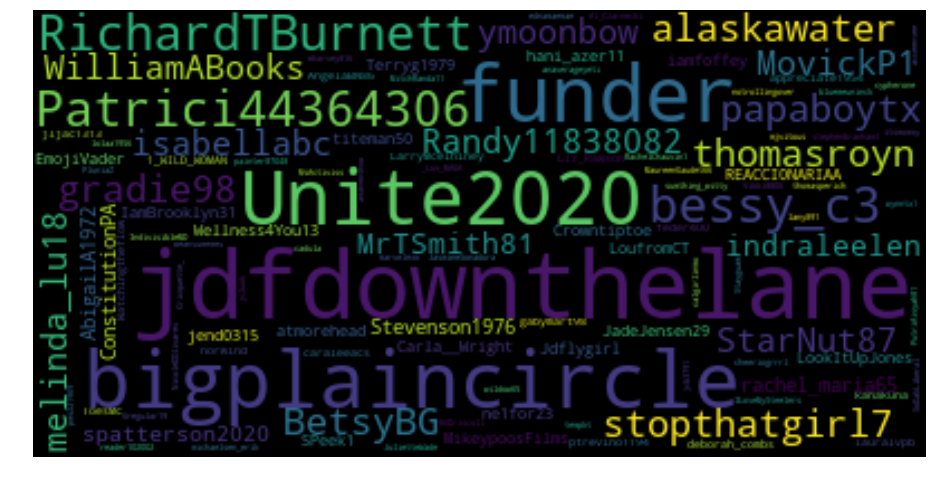

In [78]:
# USERNAME

# Generate a word cloud image
text = ' '.join(tweets_df['screen_name'])
wordcloud = WordCloud().generate(text) #WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


(-0.5, 399.5, 199.5, -0.5)

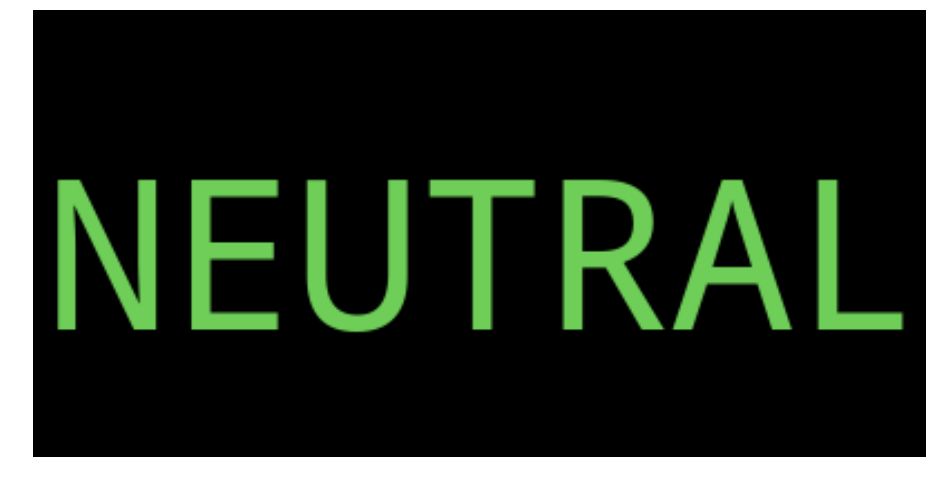

In [79]:
#Sentiment

# Generate a word cloud image
text = ' '.join(tweets_df['sentiment'])
wordcloud = WordCloud().generate(text) #WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
